In [101]:
import sys
sys.path.append('../../')


import biosppy.signals.ecg as ecg
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, RobustScaler
import sklearn
from sklearn.model_selection import train_test_split

import pywt
import neurokit2 as nk

In [78]:
%%time
X = pd.read_csv('data/X_train.csv')

CPU times: user 35.8 s, sys: 1.11 s, total: 36.9 s
Wall time: 37.3 s


In [83]:
%%time
X_test = pd.read_csv('data/X_test.csv')

CPU times: user 23.5 s, sys: 436 ms, total: 23.9 s
Wall time: 24 s


In [4]:
%%time
y = pd.read_csv('data/y_train.csv')

CPU times: user 1.47 ms, sys: 568 µs, total: 2.04 ms
Wall time: 1.61 ms


In [164]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y.y)

In [5]:
def plot_hrv(X, idx, sampling_rate=300):
    results = []
    if type(idx) == int:
            idx = range(idx)

    for i in idx:
        plt.figure(figsize=(10, 10))
        signal_raw = X.iloc[i].dropna()
        signals, info = nk.ecg_process(signal_raw, sampling_rate)
        hrv = nk.hrv(info, sampling_rate, show=True)
        results.append(hrv)
    return results

In [8]:
def compute_hrv(X, sampling_rate=150):
    results = []
    for i in tqdm(range(len(X))):
        signal_no_nan = X.iloc[i].dropna()
        signals, info = nk.ecg_process(signal_no_nan, sampling_rate)
        hrv = nk.hrv(info, sampling_rate, show=False)
        results.append(hrv)
    return results

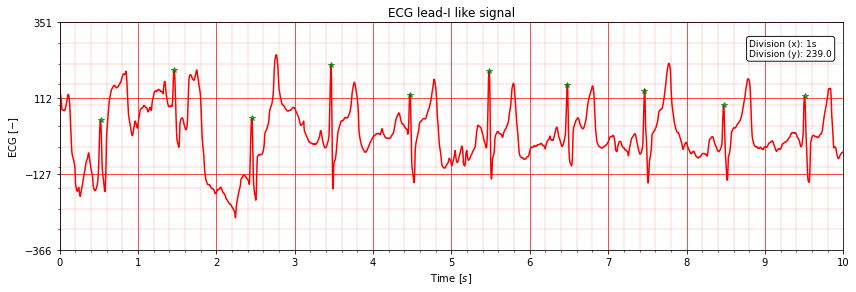

ReturnTuple(ecg_plot=<Figure size 864x288 with 1 Axes>)

In [82]:
pyhrv.tools.plot_ecg(X.iloc[166].dropna(), sampling_rate=300)

In [124]:
def get_quality(signal_raw, sampling_rate=300):
    signal_no_nan = signal_raw.dropna()
    signal, _ = nk.ecg_process(signal_no_nan, sampling_rate)
    return signal['ECG_Quality']

def get_quality2(signal_raw, sampling_rate=300):
    ecg_cleaned = nk.ecg_clean(signal_raw, sampling_rate)
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate, method="zhao2018", approach="fuzzy")
    return quality

In [67]:
i=481
signal_raw = X.iloc[i]
q = get_quality(signal_raw).mean()

In [130]:
trouble_makers = [166, 1383, 1870, 1933, 2276, 2355, 2433, 2448, 2780, 3145, 3826, 4388, 4593, 4900]

quality = []
for i in tqdm(range(len(X))):
    #if i in trouble_makers:
    #    continue
    signal_raw = X.iloc[i]
    q = get_quality2(signal_raw)
    quality.append(q)

100%|██████████| 5117/5117 [01:27<00:00, 58.26it/s]


In [107]:
robust_scaler = RobustScaler()
X_scaled = robust_scaler.fit_transform(X, y)
X_weird = pd.DataFrame(X_scaled[trouble_makers])

In [127]:
quality = []
for i in tqdm(trouble_makers):
    signal_raw = X.iloc[i]
    q = get_quality2(signal_raw)
    quality.append(q)

100%|██████████| 14/14 [00:00<00:00, 54.10it/s]


In [131]:
y_extended = pd.DataFrame({'class': y.y, 'quality':quality})

In [140]:
noise_idx = y[y.y == 3].index

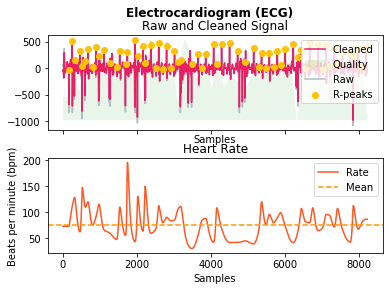

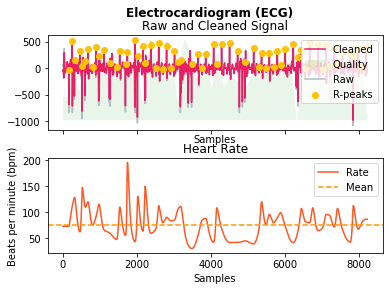

In [150]:
i = 3
signal = X.iloc[noise_idx].iloc[i].dropna()
signals, _ = nk.ecg_process(signal, sampling_rate)
nk.ecg_plot(signals)

In [223]:
def extract_variance(signal, sr=300):
    r_peaks = ecg.engzee_segmenter(signal, sr)['rpeaks']
    beats = ecg.extract_heartbeats(signal, r_peaks, sr)['templates']
    var = np.std(beats, axis=0)
    return var

def apply_on_all(data, transformation, trouble_makers=[]):
    result = []
    for i in tqdm(range(len(data))):
        if i in trouble_makers:
            continue
        if type(data) == pd.DataFrame:
            signal_raw = data.iloc[i].dropna()
        else:
            signal_raw = data[i]
        result.append(transformation(signal_raw))
        
    return result

def mean_nan(data_array):
    if np.isnan(data_array).any():
        return -100
    return data_array.mean()

def var_nan(data_array):
    if np.isnan(data_array).any():
        return -100
    return data_array.std()

In [167]:
var_train = apply_on_all(X_train, extract_variance)

100%|██████████| 3837/3837 [05:35<00:00, 11.43it/s]


In [224]:
result_mean = apply_on_all(var_train, mean_nan)
result_var = apply_on_all(var_train, var_nan)

result_mean = np.stack(result_mean)
result_var = np.stack(result_var)
result = np.stack([result_mean, result_var], axis=1)
result.shape

100%|██████████| 3837/3837 [00:00<00:00, 48977.58it/s]


(3837, 2)

In [230]:
idx_nan = np.where(result_mean == -100)[0]

In [231]:
y_mapped = y_train.y.map(lambda x: 0 if x in [3] else 1).values
y_mapped[idx_nan]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

<AxesSubplot:>

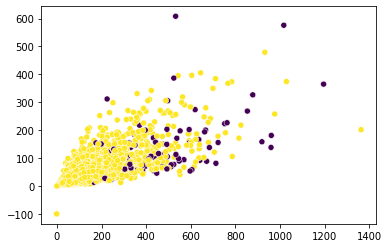

In [219]:
sns.scatterplot(x=result[:, 0], y=result[:, 1], c=y_mapped)

In [ ]:
labels_noise_vs_rest = y.apply_map(lambda x: 0 if x in [3] else 1)

In [54]:
# Find peaks
X_train = X
sampling_rate = 150
sample_id = 474
thresh=0.48

signal_raw = X_train.iloc[sample_id].dropna()

rpeaks_ecg = ecg.engzee_segmenter(signal_raw, sampling_rate, threshold=thresh)['rpeaks']
info_ecg = {'ECG_R_Peaks': rpeaks_ecg, 'sampling_rate':sampling_rate}

signals_nk, info_nk = nk.ecg_process(signal_raw, sampling_rate)
#peaks, info = nk.ecg_peaks(signals, sampling_rate=sampling_rate)
nk.hrv(info_nk, sampling_rate, show=True)
#nk.events_plot(signals_nk['ECG_R_Peaks'], signals_nk['ECG_Clean'], )
#nk.ecg_plot(signals_nk)

ValueError: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'windows'.

In [ ]:
_, rpeaks = nk.ecg_peaks(signal_raw, sampling_rate=150)
plot = nk.events_plot(rpeaks['ECG_R_Peaks'], signal_raw)

In [58]:
compute_hrv(X_train.iloc[:])

  1%|          | 47/5117 [00:15<28:34,  2.96it/s]


ValueError: NeuroKit error: the window cannot contain more data points than the time series. Decrease 'windows'.

In [11]:
import pyhrv

<Figure size 1440x1440 with 0 Axes>

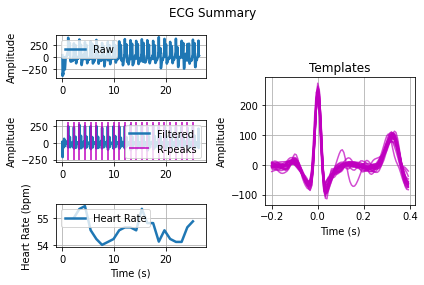

In [73]:
sampling_rate = 150
sample_id = 35
thresh=0.48

signal_raw = X.iloc[sample_id].dropna()
figure = plt.figure(figsize=(20, 20))
filtered_signal, rpeaks = ecg.ecg(signal_raw, sampling_rate)[1:3]

/Users/jodok/02 Code/spring21-JodokVieli/venv/lib/python3.8/site-packages/pyhrv/utils.py:368: UserWarning: Signal duration is to short for segmentation into 300000s. Input data will be returned.
  warnings.warn("Signal duration is to short for segmentation into %is. Input data will be returned." % duration)
/Users/jodok/02 Code/spring21-JodokVieli/venv/lib/python3.8/site-packages/pyhrv/time_domain.py:303: UserWarning: Signal duration too short for SDANN computation.
  warnings.warn("Signal duration too short for SDANN computation.")
/Users/jodok/02 Code/spring21-JodokVieli/venv/lib/python3.8/site-packages/pyhrv/time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '


AssertionError: lag must be less than len(x)

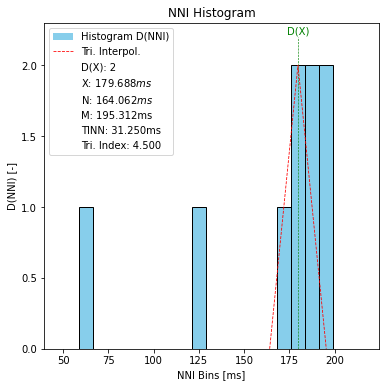

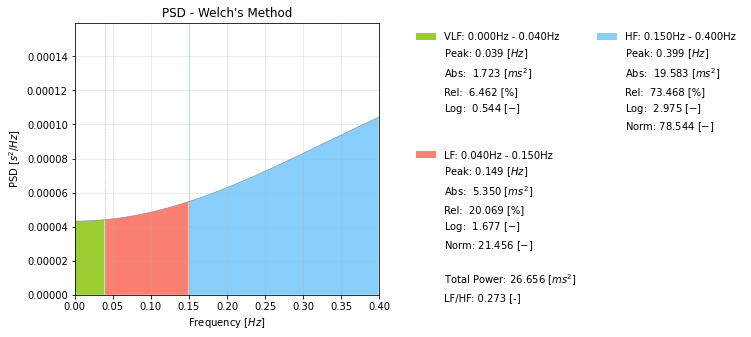

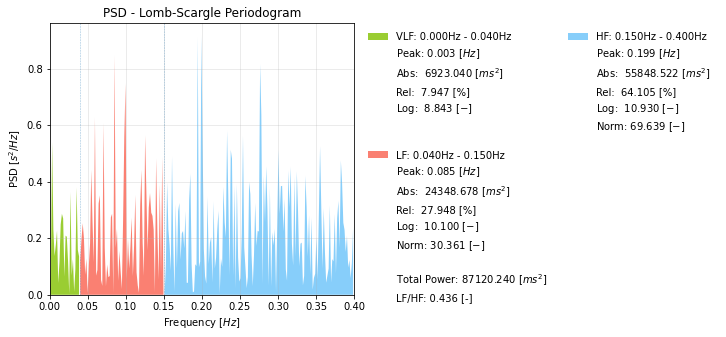

In [52]:
results = pyhrv.hrv(signal=signal_raw, sampling_rate=sampling_rate)

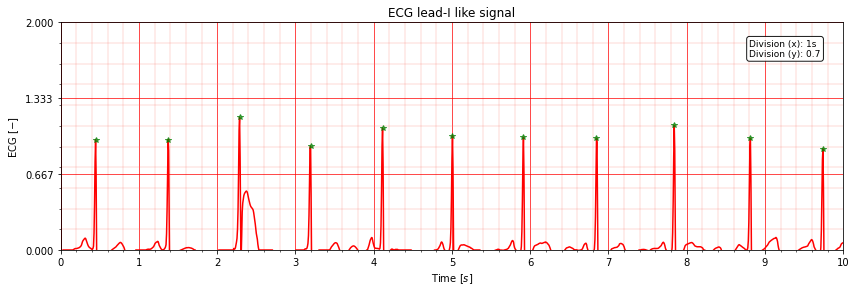

ReturnTuple(ecg_plot=<Figure size 864x288 with 1 Axes>)

In [43]:
pyhrv.tools.plot_ecg(signal_raw, sampling_rate=sampling_rate)

In [42]:
pd.DataFrame({'keys': results.keys(), 'values':results})

,keys,values
0,nni_counter,35
1,nni_mean,118.257
2,nni_min,104
3,nni_max,130
4,hr_mean,508.962
...,...,...
70,dfa_alpha2,nan
71,dfa_alpha1_beats,"(4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)"
72,dfa_alpha2_beats,"(17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2..."
73,ecg_plot,Figure(864x288)
